# THIS NOTEBOOK IS DEDICATED TO THE ANALYSIS OF 

# *SEQ SCORE / WAITING TIME*


In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

param={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }
Y1,Y2=(0,90)
BadLateRats=('Rat223','Rat231')
print('Done')

In [26]:
def plot_event_1on1(root, SessionDict, TaskParamToPlot,
                    ax=None, preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    Plot = True
    if ax is None:
        Plot=False
    
    
    Results,nSessionPre,nSessionPost=event_statistic(root,
                                                     SessionDict,
                                                     parameter=param,
                                                     redo=True,
                                                     TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    y0=np.nanmean(slicedPreData,axis=1)
    y1=np.nanmean(slicedPostData,axis=1)
    
    y=np.array([y0,y1]).T
    
    if Plot:
        #plotting the errorbar
        props={'color':'k','linewidth':1}
        ax.boxplot(x=y,whis=[5,95],
                      positions=[-.5,.5], widths=.3,
                      showcaps=False, showfliers=False,
                      medianprops=props, boxprops=props, whiskerprops=props,
                      zorder=2)

        #plotting single animals
        for before,after in y:
            ax.plot([-.5,.5],[before,after],lw=.5,alpha=1,zorder=1)
        
    return y, slicedPreData, slicedPostData

## motor seq score

In [44]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'10',
         'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
          'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
          'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
         }
profile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'10',
         'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
         }

Profiles=(profile1,profile2)
TaskParamToPlot=["Motor Sequence Score","Maximum Position"]
preSlice=slice(-5,None)
postSlice=slice(-5,None)

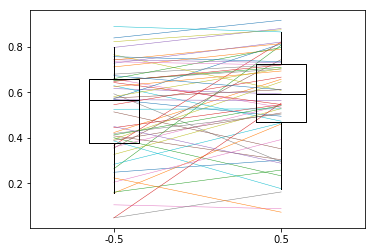

In [28]:
badAnimalList=BadLateRats

F=plt.figure(1)
ax=F.add_subplot(111)

_,SessionDict=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)
y, nSessionPre, slicedPostData=plot_event_1on1(root,SessionDict, TaskParamToPlot=TaskParamToPlot[0],
                                               ax=ax, preSlice=preSlice, postSlice=postSlice);
clear_output()
F

In [29]:
for i,animal in enumerate(SessionDict.keys()):
    print(i, animal,y[i,0],y[i,1],y[i,1]-y[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


0	Rat221	0.5687204808930872	0.4952140065639464	-0.07350647432914087
1	Rat226	0.4233865081847565	0.658004041311181	0.23461753312642447
2	Rat163	0.2637655295610295	0.807844196780367	0.5440786672193375
3	Rat232	0.44470475004361243	0.5463834422657952	0.10167869222218273
4	Rat161	0.6168013114701308	0.5933905778602925	-0.023410733609838363
5	Rat124	0.40884484228473994	0.30402007708853473	-0.1048247651962052
6	Rat308	0.6593465678145222	0.5337534549474847	-0.12559311286703745
7	Rat251	0.5938960509698064	0.29445203666175945	-0.2994440143080469
8	Rat217	0.3940249282829603	0.6470548487909052	0.2530299205079449
9	Rat301	0.6294010304851868	0.47341316413021006	-0.15598786635497675
10	Rat085	0.839603963493882	0.9174999999999999	0.07789603650611787
11	Rat302	0.7121087565460967	0.7898582843358962	0.07774952778979949
12	Rat123	0.40080002009182875	0.23303974128314012	-0.16776027880868863
13	Rat222	0.36780916111287426	0.8219376456876457	0.45412848457477145
14	Rat131	0.5683806747372474	0.563513956480209	-0

### maximum position

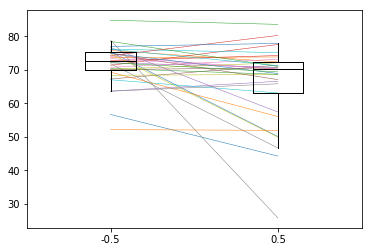

In [51]:
badAnimalList=[*BadLateRats]
for i,animal in enumerate(SessionDict.keys()):
    if y[i,0] < 0.4 or y[i,1] < 0.4: #low seq score
        badAnimalList.append(animal)

F=plt.figure(2)
ax=F.add_subplot(111)

_,SessionDict1=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)
y1, nSessionPre1, slicedPostData1=plot_event_1on1(root,SessionDict1, TaskParamToPlot=TaskParamToPlot[1],ax=ax,
                                                  preSlice=slice(-2,None), postSlice=slice(0,3));
clear_output()
F

In [52]:
for i,animal in enumerate(SessionDict1.keys()):
    print(i, animal,y1[i,0],y1[i,1],y1[i,1]-y1[i,0] ,sep='\t')
#     if y[i,1] < 0.4:
#         print(i, animal, y[i,0],y[i,1], sep='\t')


0	Rat221	75.35504641972653	50.053757347491086	-25.30128907223545
1	Rat226	75.76302988647222	72.3394802618099	-3.4235496246623285
2	Rat232	84.7614566384037	83.5360540003086	-1.2254026380951046
3	Rat161	71.32141259475596	77.52325322765454	6.2018406328985805
4	Rat308	63.61466160450757	66.5473745334893	2.9327129289817364
5	Rat301	67.2251159749713	71.37308756259897	4.147971587627666
6	Rat085	74.02459489956567	70.12478822700086	-3.8998066725648073
7	Rat302	71.80612626187789	46.6616030711499	-25.144523190727995
8	Rat131	68.35124894941832	68.56962244088345	0.21837349146512963
9	Rat113	76.12939451826664	75.10285094113767	-1.0265435771289617
10	Rat227	56.65019242614599	44.22530310630297	-12.424889319843025
11	Rat122	73.65627519386165	73.80457612451744	0.1483009306557932
12	Rat137	70.37259492844231	68.63100732692295	-1.741587601519356
13	Rat091	72.69503569346423	74.23607486054583	1.5410391670815926
14	Rat120	72.06977490668814	70.69653484010321	-1.373240066584927
15	Rat299	74.83602709710837	67.041

In [53]:
x=y1[:,0]-y1[:,1]
# x[y[:,0]<3.5]=np.nan
x=x[~ np.isnan(x)]
q=np.random.normal(loc=0.0, scale=np.std(x), size=(500,1))
p=permtest(x=x, y=q, iterN=10000)

In [54]:
p.p_val

array([0.00729927])

## correlation with lesion size

In [65]:
def late_lesion_correlation_with_size(root: str, SessionDict:dict, TaskParamToPlot:str,
                                      preSlice=slice(-5,None), postSlice=slice(0,5)):
    """
    SessionDict is the output of the function `event_detect`
    """
    
    Results,nSessionPre,nSessionPost=event_statistic(root,
                                                 SessionDict,
                                                 parameter=param,
                                                 redo=False,
                                                 TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    yPre =np.nanmean(slicedPreData ,axis=1)
    yPost=np.nanmean(slicedPostData,axis=1)

    size=[]
    behav=[]
    animals=[]
    for i,animal in enumerate(Results[TaskParamToPlot].keys()):
        try:
            Hist=HistologyExcel('/NAS02',animal)
        except Exception as e:
            logging.error(f'{animal}: {repr(e)}')
            continue
        
        behav.append(yPost[i]/yPre[i])
        size.append(Hist.lesion_size())
        animals.append(animal)
    
    return behav, size, animals

In [66]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }

    Profiles=(profile1,profile2)
    TaskParamToPlot=["Motor Sequence Score","Maximum Position"]
    preSlice=slice(-5,None)
    postSlice=slice(-5,None)
    badAnimalList=list(BadLateRats)
    _,SessionDict=event_detect(root, Profiles[0], Profiles[1],badAnimals=badAnimalList)

    Behav, Size, Animals=late_lesion_correlation_with_size(root, SessionDict, TaskParamToPlot=TaskParamToPlot[1],
                                                           preSlice=slice(-5,None), postSlice=slice(0,5))

NameError('Rat124 :pickle not complete, computing again...')
NameError('Rat123 :pickle not complete, computing again...')
NameError('Rat122 :pickle not complete, computing again...')
NameError('Rat121 :pickle not complete, computing again...')


ERROR:root:Rat124: AssertionError('No Excel files/NAS02/Rat124/Rat124*.xls*')
ERROR:root:Rat123: AssertionError('No Excel files/NAS02/Rat123/Rat123*.xls*')
ERROR:root:Rat122: AssertionError('No Excel files/NAS02/Rat122/Rat122*.xls*')
ERROR:root:Rat121: AssertionError('No Excel files/NAS02/Rat121/Rat121*.xls*')


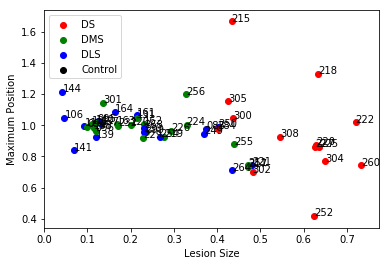

In [67]:
if "__file__" not in dir():
    color={'DS':'r','DMS':'g', 'DLS':'b', 'Control':'k'}
    
    ax=plt.subplot(111)
    for i,animal in enumerate(Animals):
        _,tag=lesion_type(root,animal)
        ax.scatter(Size[i], Behav[i], c=color[tag], label=tag);
        plt.annotate(animal[-3:], (Size[i],Behav[i]))
    ax.set_ylabel(TaskParamToPlot[1]);
    ax.set_xlabel('Lesion Size');
    handles = ax.get_legend_handles_labels()
    handles = [handles[0][-2], handles[0][-1], handles[0][-3],handles[0][-4]]
    ax.legend(handles, color.keys());
    leg = ax.get_legend()
    for i,c in enumerate(color.values()):
        leg.legendHandles[i].set_color(c)